In [20]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt

In [21]:
file_path = 'data\\robustShapeMean2D.mat'
mat = scipy.io.loadmat(file_path)

In [22]:
print(mat.keys())
print(f"header: {mat['__header__']}")
print(f"version: {mat['__version__']}")
print(f"globals: {mat['__globals__']}")
print(f"pointsets shape: {mat['pointsets'].shape}")

dict_keys(['__header__', '__version__', '__globals__', 'pointsets'])
header: b'MATLAB 5.0 MAT-file Platform: posix, Created on: Wed Mar 26 22:25:33 2025'
version: 1.0
globals: []
pointsets shape: (357, 32, 2)


In [23]:
pointsets = []
for pointset in mat['pointsets']:
    p_cent = pointset - np.mean(pointset, axis=0)
    norm_p = np.linalg.norm(p_cent)
    p_norm = p_cent/norm_p
    pointsets.append(np.array(p_norm).T)

In [24]:
print(len(pointsets))

357


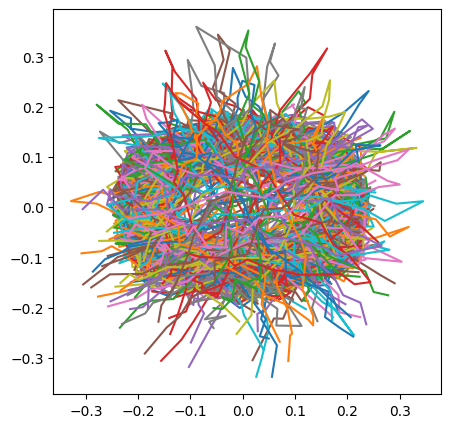

In [25]:
plt.figure(figsize=(5, 5))
for p in pointsets:
    plt.plot(p[0], p[1])


In [26]:
# For further processing, it is more convenient to have each shape as a (32,2) array.
# Convert our pointsets from shape (2,32) back to (32,2):
shapes = [p.T for p in pointsets]  # now each shape has shape (32, 2)
num_shapes = len(shapes)

In [27]:

# ------------------------------------------
# Step 2: Define the Procrustes Alignment Code
# ------------------------------------------
def procrustes_align(A, B):
    """
    Align shape B to shape A using a similarity transformation.
    Steps:
      1. Remove translation by centering both shapes.
      2. Remove scale by normalizing.
      3. Compute optimal rotation using Singular Value Decomposition (SVD).
      4. Reintroduce scale and translation.
    
    Parameters:
        A: Reference shape (num_points x 2)
        B: Shape to be aligned (num_points x 2)
    
    Returns:
        B_aligned: Aligned version of B
    """
    # Center the shapes (remove translation)
    A_cent = A - np.mean(A, axis=0)
    B_cent = B - np.mean(B, axis=0)
    
    # Normalize to remove scale differences
    norm_A = np.linalg.norm(A_cent)
    norm_B = np.linalg.norm(B_cent)
    
    A_norm = A_cent / norm_A
    B_norm = B_cent / norm_B
    
    # Compute optimal rotation using SVD on cross-covariance matrix
    U, _, Vt = np.linalg.svd(B_norm.T @ A_norm)
    R = U @ Vt
    
    # Apply rotation, scale, and reintroduce the translation from A
    B_aligned = (B_cent / norm_B) @ R * norm_A + np.mean(A, axis=0)
    return B_aligned

# -----------------------------------------------------------------------------------------
# Step 3a: Compute the Mean Shape by Minimizing Sum of Squared Procrustes Distances (L2 formulation)
# -----------------------------------------------------------------------------------------
def compute_robust_mean_squared(shapes, max_iter=10):
    """
    Compute the mean shape by minimizing the sum of squared Procrustes distances.
    This is done iteratively:
      - Align each shape to the current estimate of the mean.
      - Update the mean as the arithmetic average of all aligned shapes.
    
    Parameters:
        shapes: List of arrays, each with shape (num_points, 2)
        max_iter: Number of iterations
        
    Returns:
        mean_shape: The computed mean shape (num_points x 2)
        aligned: A list of aligned shapes
    """
    # Initialize mean as the first shape in the list
    mean_shape = shapes[0]
    
    for it in range(max_iter):
        aligned_list = []
        for shape in shapes:
            aligned_shape = procrustes_align(mean_shape, shape)
            aligned_list.append(aligned_shape)
        aligned = np.stack(aligned_list, axis=2)  # shape: (num_points, 2, num_shapes)
        # Update the mean by taking the average across the third dimension (all shapes)
        mean_shape = np.mean(aligned, axis=2)
    
    return mean_shape, aligned

# ------------------------------------------------------------------------------------------
# Step 3b: Compute the Mean Shape by Minimizing Sum of Procrustes Distances (L1 formulation)
# ------------------------------------------------------------------------------------------
def compute_robust_mean_linear(shapes, max_iter=10, eps=1e-6):
    """
    Compute the robust mean shape by minimizing the sum of Procrustes distances (L1 formulation).
    Uses a Weiszfeld-like algorithm:
      - Align each shape to the current mean.
      - Compute weights inversely proportional to the distance from the current mean.
      - Update the mean as the weighted average of the aligned shapes.
    
    Parameters:
        shapes: List of arrays, each with shape (num_points, 2)
        max_iter: Number of iterations
        eps: Small constant to avoid division by zero
    
    Returns:
        mean_shape: The computed robust mean shape (num_points x 2)
        aligned: A list of aligned shapes
    """
    mean_shape = shapes[0]
    
    for it in range(max_iter):
        aligned_list = []
        weights = []
        for shape in shapes:
            aligned_shape = procrustes_align(mean_shape, shape)
            aligned_list.append(aligned_shape)
            # Compute Euclidean distance between the current mean and aligned shape
            dist = np.linalg.norm(mean_shape - aligned_shape)
            weights.append(1 / (dist + eps))  # avoid division by zero
        
        weights = np.array(weights)
        aligned = np.stack(aligned_list, axis=2)
        # Compute weighted sum of the aligned shapes
        weighted_sum = np.tensordot(aligned, weights, axes=(2, 0))
        # Normalize by the sum of the weights to get the updated mean
        mean_shape = weighted_sum / np.sum(weights)
    
    return mean_shape, aligned


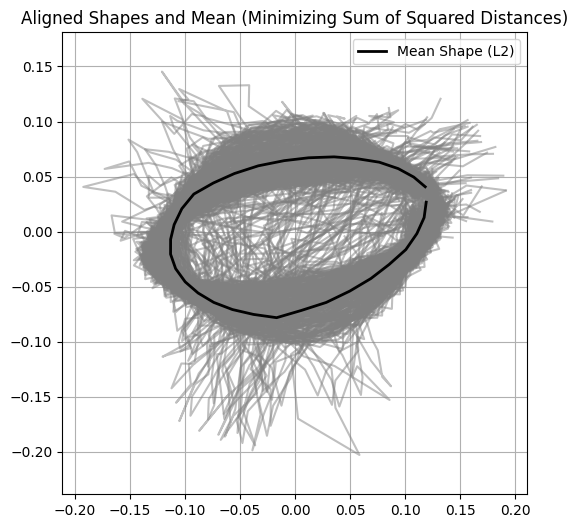

In [28]:

# ---------------------------------------------------
# Step 4: Compute the Means and Visualize the Results
# ---------------------------------------------------
# Compute robust mean using the squared distances (L2)
mean_sq, aligned_sq = compute_robust_mean_squared(shapes, max_iter=15)

plt.figure(figsize=(6, 6))
plt.title("Aligned Shapes and Mean (Minimizing Sum of Squared Distances)")
for i in range(num_shapes):
    plt.plot(aligned_sq[:, 0, i], aligned_sq[:, 1, i], color='gray', alpha=0.5)
plt.plot(mean_sq[:, 0], mean_sq[:, 1], color='black', linewidth=2, label="Mean Shape (L2)")
plt.legend()
plt.axis("equal")
plt.grid(True)
plt.show()


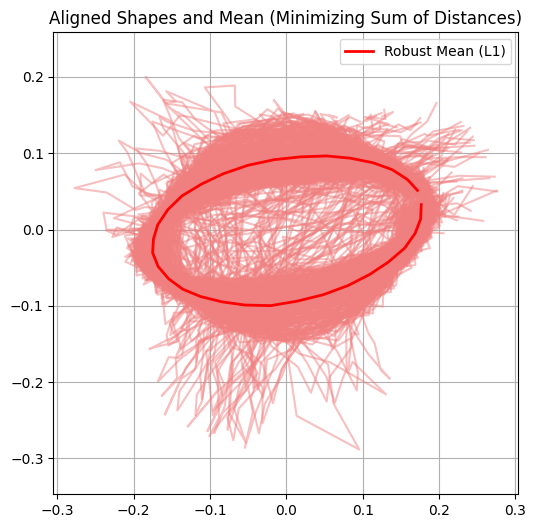

In [29]:

# Compute robust mean using the linear distances (L1)
mean_lin, aligned_lin = compute_robust_mean_linear(shapes, max_iter=15)

plt.figure(figsize=(6, 6))
plt.title("Aligned Shapes and Mean (Minimizing Sum of Distances)")
for i in range(num_shapes):
    plt.plot(aligned_lin[:, 0, i], aligned_lin[:, 1, i], color='lightcoral', alpha=0.5)
plt.plot(mean_lin[:, 0], mean_lin[:, 1], color='red', linewidth=2, label="Robust Mean (L1)")
plt.legend()
plt.axis("equal")
plt.grid(True)
plt.show()